# Exploring the NHC Advisories and Sea Surface Height during Hurricane Irma


This notebook aims to demonstrate how to create a simple interactive GIS map with the National Hurricane Center predictions [1] and the observed sea surface height from CO-OPS [2].


See https://tidesandcurrents.noaa.gov/quicklook/view.html?name=IRMA for the latest information on Irma.

1. http://www.nhc.noaa.gov/gis/
2. https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/


First we have to download the National Hurricane Center (NHC) GIS 5 day predictions data for Irma.

NHC codes storms are coded with 8 letter names:
- 2 char for region `al` &rarr; Atlantic
- 2 char for number `11` is Irma
- and 4 char for year, `2017`

Browse http://www.nhc.noaa.gov/gis/archive_wsurge.php?year=2017 to find other hurricanes code.

In [1]:
code = "al112017"
hurricane = "{}_5day".format(code)

In [2]:
import os
import sys

import lxml.html

try:
    from urllib.request import urlopen, urlretrieve
except Exception:
    from urllib import urlopen, urlretrieve


def url_lister(url):
    urls = []
    connection = urlopen(url)
    dom = lxml.html.fromstring(connection.read())
    for link in dom.xpath("//a/@href"):
        urls.append(link)
    return urls


def download(url, path):
    sys.stdout.write(fname + "\n")
    if not os.path.isfile(path):
        urlretrieve(url, filename=path, reporthook=progress_hook(sys.stdout))
        sys.stdout.write("\n")
        sys.stdout.flush()


def progress_hook(out):
    """
    Return a progress hook function, suitable for passing to
    urllib.retrieve, that writes to the file object *out*.
    """

    def it(n, bs, ts):
        got = n * bs
        if ts < 0:
            outof = ""
        else:
            # On the last block n*bs can exceed ts, so we clamp it
            # to avoid awkward questions.
            got = min(got, ts)
            outof = "/%d [%d%%]" % (ts, 100 * got // ts)
        out.write("\r  %d%s" % (got, outof))
        out.flush()

    return it

In [3]:
nhc = "http://www.nhc.noaa.gov/gis/forecast/archive/"

# We don't need the latest file b/c that is redundant to the latest number.
fnames = [
    fname
    for fname in url_lister(nhc)
    if fname.startswith(hurricane) and "latest" not in fname
]

In [4]:
base = os.path.abspath(os.path.join(os.path.curdir, "data", hurricane))

if not os.path.exists(base):
    os.makedirs(base)

for fname in fnames:
    url = "{}/{}".format(nhc, fname)
    path = os.path.join(base, fname)
    download(url, path)

al112017_5day_001.zip
al112017_5day_002.zip
al112017_5day_003.zip
al112017_5day_004.zip
al112017_5day_005.zip
al112017_5day_006.zip
al112017_5day_007.zip
al112017_5day_008.zip
al112017_5day_009.zip
al112017_5day_010.zip
al112017_5day_011.zip
al112017_5day_012.zip
al112017_5day_013.zip
al112017_5day_014.zip
al112017_5day_015.zip
al112017_5day_016.zip
al112017_5day_017.zip
al112017_5day_018.zip
al112017_5day_018A.zip
al112017_5day_019.zip
al112017_5day_019A.zip
al112017_5day_020.zip
al112017_5day_020A.zip
al112017_5day_021.zip
al112017_5day_021A.zip
al112017_5day_022.zip
al112017_5day_022A.zip
al112017_5day_023.zip
al112017_5day_023A.zip
al112017_5day_024.zip
al112017_5day_025.zip
al112017_5day_026.zip
al112017_5day_026A.zip
al112017_5day_027.zip
al112017_5day_027A.zip
al112017_5day_028.zip
al112017_5day_028A.zip
al112017_5day_029.zip
al112017_5day_029A.zip
al112017_5day_030.zip
al112017_5day_030A.zip
al112017_5day_031.zip
al112017_5day_031A.zip
al112017_5day_032.zip
al112017_5day_032A.z

In the cells below we use `geopandas` to load the data we just downloaded. We will use only the prediction cone (`png`) and the track points (`pts`), but feel free to explore this data further, there is plenty more there.

In [5]:
import os

os.environ["CPL_ZIP_ENCODING"] = "UTF-8"
os.environ["TZ"] = "GMT0"

In [6]:
from glob import glob

import geopandas

cones, points = [], []
for fname in sorted(glob(os.path.join(base, "{}_*.zip".format(hurricane)))):
    number = os.path.splitext(os.path.split(fname)[-1])[0].split("_")[-1]
    pgn = geopandas.read_file(
        "/{}-{}_5day_pgn.shp".format(code, number), vfs="zip://{}".format(fname)
    )
    cones.append(pgn)

    pts = geopandas.read_file(
        "/{}-{}_5day_pts.shp".format(code, number), vfs="zip://{}".format(fname)
    )
    # Only the first "obsevartion."
    points.append(pts.iloc[0])

Let's create a color code for the point track.

In [7]:
colors = {
    "Subtropical Depression": "yellow",
    "Tropical Depression": "yellow",
    "Tropical Storm": "orange",
    "Subtropical Storm": "orange",
    "Hurricane": "red",
    "Major Hurricane": "crimson",
}

Now we can get all the information we need from those GIS files. Let's start with the event dates.

In [8]:
import dateutil

start = points[0]["FLDATELBL"].strip(" AST")
end = points[-1]["FLDATELBL"].strip(" EDT")

start = dateutil.parser.parse(start)
end = dateutil.parser.parse(end)

And the bounding box to search the data.

In [9]:
from shapely.geometry import LineString
from shapely.ops import cascaded_union

last_cone = cones[-1]["geometry"].iloc[0]
track = LineString([point["geometry"] for point in points])

polygon = cascaded_union([last_cone, track])

# Add a buffer to find the stations along the track.
bbox = polygon.buffer(2).bounds

Note that the bounding box is derived from the track and the latest prediction cone.

In [10]:
strbbox = ", ".join(format(v, ".2f") for v in bbox)
print("bbox: {}\nstart: {}\n  end: {}".format(strbbox, start, end))

bbox: -91.91, 14.40, -28.30, 39.45
start: 2017-08-30 08:00:00
  end: 2017-09-11 20:00:00


Now we need to build a filter with those parameters to find the observations along the Hurricane path. We still need to specify:

- the units for the observations;
- and the SOS name for the variables of interest.

Next, we can use `pyoos` to assemble a collector to download the data into a pandas `DataFrame`.

In [11]:
import cf_units
import pandas as pd
from ioos_tools.ioos import collector2table
from pyoos.collectors.coops.coops_sos import CoopsSos
from retrying import retry


# We need to retry in case of failure b/c the server cannot handle
# the high traffic during events like Irma.
@retry(stop_max_attempt_number=5, wait_fixed=3000)
def get_coops(start, end, sos_name, units, bbox, verbose=False):
    collector = CoopsSos()
    collector.set_bbox(bbox)
    collector.end_time = end
    collector.start_time = start
    collector.variables = [sos_name]
    ofrs = collector.server.offerings
    title = collector.server.identification.title
    config = dict(units=units, sos_name=sos_name,)

    data = collector2table(
        collector=collector,
        config=config,
        col="{} ({})".format(sos_name, units.format(cf_units.UT_ISO_8859_1)),
    )

    # Clean the table.
    table = dict(
        station_name=[s._metadata.get("station_name") for s in data],
        station_code=[s._metadata.get("station_code") for s in data],
        sensor=[s._metadata.get("sensor") for s in data],
        lon=[s._metadata.get("lon") for s in data],
        lat=[s._metadata.get("lat") for s in data],
        depth=[s._metadata.get("depth", "NA") for s in data],
    )

    table = pd.DataFrame(table).set_index("station_name")
    if verbose:
        print("Collector offerings")
        print("{}: {} offerings".format(title, len(ofrs)))
    return data, table

In [12]:
ssh, ssh_table = get_coops(
    start=start,
    end=end,
    sos_name="water_surface_height_above_reference_datum",
    units=cf_units.Unit("meters"),
    bbox=bbox,
)

ssh_table

station_code  \
station_name                                                
Bermuda Biological Station                        2695535   
Bermuda, St. Georges Island, Bermuda              2695540   
Atlantic City, NJ                                 8534720   
Cape May, NJ                                      8536110   
Ship John Shoal, NJ                               8537121   
Brandywine Shoal Light, DE                        8555889   
Lewes, DE                                         8557380   
Ocean City Inlet, MD                              8570283   
Bishops Head, MD                                  8571421   
Cambridge, MD                                     8571892   
Tolchester Beach, MD                              8573364   
Baltimore, Fort McHenry, Patapsco River, MD       8574680   
Annapolis, MD                                     8575512   
Solomons Island, MD                               8577330   
Washington, DC                                    8594900   
Wachapreague, VA                                  8631044   
Kiptopeke, VA                                     8632200   
Dahlgren, VA                                      8635027   
Lewisetta, VA                                     8635750   
Windmill Point, VA                                8636580   
Yorktown USCG Training Center, VA                 8637689   
Sewells Point, VA                                 8638610   
CBBT, Chesapeake Channel, VA                      8638901   
Money Point, VA                                   8639348   
Duck, NC                                          8651370   
Oregon Inlet Marina, NC                           8652587   
USCG Station Hatteras, NC                         8654467   
Beaufort, Duke Marine Lab, NC                     8656483   
Wilmington, NC                                    8658120   
Wrightsville Beach, NC                            8658163   
...                                                   ...   
West Fowl River Bridge, AL                        8738043   
Bayou La Batre Bridge, AL                         8739803   
Pascagoula NOAA Lab, MS                           8741533   
Bay Waveland Yacht Club, MS                       8747437   
Pilottown, LA                                     8760721   
Pilots Station East, S.W. Pass, LA                8760922   
Shell Beach, LA                                   8761305   
Grand Isle, LA                                    8761724   
New Canal Station, LA                             8761927   
Carrollton, LA                                    8761955   
Port Fourchon, Belle Pass, LA                     8762075   
West Bank 1, Bayou Gauche, LA                     8762482   
I-10 Bonnet Carre Floodway, LA                    8762483   
Berwick, Atchafalaya River, LA                    8764044   
LAWMA, Amerada Pass, LA                           8764227   
Eugene Island, North of , Gulf of Mexico, LA      8764314   
Christiansted Harbor, St Croix, VI                9751364   
Lameshur Bay, St John, VI                         9751381   
Lime Tree Bay, VI                                 9751401   
Charlotte Amalie, VI                              9751639   
Culebra, PR                                       9752235   
Isabel Segunda, Vieques Island, PR                9752619   
Esperanza, Vieques Island, PR                     9752695   
Yabucoa Harbor, PR                                9754228   
San Juan, La Puntilla, San Juan Bay, PR           9755371   
Arecibo, PR                                       9757809   
Magueyes Island, PR                               9759110   
Mayaguez, PR                                      9759394   
Mona Island, PR                                   9759938   
Barbuda, Antigua and Barbuda                      9761115   

                                                                                  sensor  \
station_name                                                                               
Bermuda Biologica

In [13]:
wind_speed, wind_speed_table = get_coops(
    start=start, end=end, sos_name="wind_speed", units=cf_units.Unit("m/s"), bbox=bbox,
)

wind_speed_table

station_code  \
station_name                                                
Bermuda, St. Georges Island, Bermuda              2695540   
Cape May, NJ                                      8536110   
Ship John Shoal, NJ                               8537121   
Brandywine Shoal Light, DE                        8555889   
Lewes, DE                                         8557380   
Ocean City Inlet, MD                              8570283   
Bishops Head, MD                                  8571421   
Tolchester Beach, MD                              8573364   
Baltimore, Fort McHenry, Patapsco River, MD       8574680   
Francis Scott Key Bridge, MD                      8574728   
Cove Point LNG Pier, MD                           8577018   
Solomons Island, MD                               8577330   
Piney Point, MD                                   8578240   
Washington, DC                                    8594900   
Wachapreague, VA                                  8631044   
Kiptopeke, VA                                     8632200   
Rappahannock Light, VA                            8632837   
Dahlgren, VA                                      8635027   
Lewisetta, VA                                     8635750   
York River East Rear Range Light, VA              8637611   
Yorktown USCG Training Center, VA                 8637689   
Dominion Terminal Associates, VA                  8638511   
South Craney Island, VA                           8638595   
Willoughby Degaussing Station, VA                 8638614   
urn:ioos:station:NOAA.NOS.CO-OPS:8638863          8638863   
CBBT, Chesapeake Channel, VA                      8638901   
Cape Henry, VA                                    8638999   
Money Point, VA                                   8639348   
Duck, NC                                          8651370   
Oregon Inlet Marina, NC                           8652587   
...                                                   ...   
Panama City, FL                                   8729108   
Panama City Beach, FL                             8729210   
Fort Morgan, AL                                   8734673   
Dauphin Island, AL                                8735180   
Coast Guard Sector Mobile, AL                     8736897   
Petit Bois Island, Port of Pascagoula, MS         8741003   
urn:ioos:station:NOAA.NOS.CO-OPS:8741094          8741094   
urn:ioos:station:NOAA.NOS.CO-OPS:8741501          8741501   
Bay Waveland Yacht Club, MS                       8747437   
Pilottown, LA                                     8760721   
Pilots Station East, S.W. Pass, LA                8760922   
Shell Beach, LA                                   8761305   
Grand Isle, LA                                    8761724   
New Canal Station, LA                             8761927   
West Bank 1, Bayou Gauche, LA                     8762482   
Berwick, Atchafalaya River, LA                    8764044   
LAWMA, Amerada Pass, LA                           8764227   
Eugene Island, North of , Gulf of Mexico, LA      8764314   
Christiansted Harbor, St Croix, VI                9751364   
Lime Tree Bay, VI                                 9751401   
Charlotte Amalie, VI                              9751639   
Isabel Segunda, Vieques Island, PR                9752619   
Esperanza, Vieques Island, PR                     9752695   
Fajardo, PR                                       9753216   
Yabucoa Harbor, PR                                9754228   
San Juan, La Puntilla, San Juan Bay, PR           9755371   
Arecibo, PR                                       9757809   
Magueyes Island, PR                               9759110   
Mayaguez, PR                                      9759394   
Barbuda, Antigua and Barbuda                      9761115   

                                                                                  sensor  \
station_name                                                                               
Bermuda, St. Geor

For simplicity we will use only the stations that have both wind speed and sea surface height and reject those that have only one or the other.

In [14]:
common = set(ssh_table["station_code"]).intersection(wind_speed_table["station_code"])

In [15]:
ssh_obs, win_obs = [], []
for station in common:
    ssh_obs.extend([obs for obs in ssh if obs._metadata["station_code"] == station])
    win_obs.extend(
        [obs for obs in wind_speed if obs._metadata["station_code"] == station]
    )

In [16]:
index = pd.date_range(start=start, end=end, freq="15min")

# Re-index and rename series.
ssh_observations = []
for series in ssh_obs:
    _metadata = series._metadata
    series.index = series.index.tz_localize(None)
    obs = series.reindex(index=index, limit=1, method="nearest")
    obs._metadata = _metadata
    obs.name = _metadata["station_name"]
    ssh_observations.append(obs)

winds_observations = []
for series in win_obs:
    _metadata = series._metadata
    series.index = series.index.tz_localize(None)
    obs = series.reindex(index=index, limit=1, method="nearest")
    obs._metadata = _metadata
    obs.name = _metadata["station_name"]
    winds_observations.append(obs)

Let's take a look at some stations to see if the data is OK. Below we have a station in Naples, FL along the Gulf of Mexico.

/home/filipe/miniconda3/envs/IOOS/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


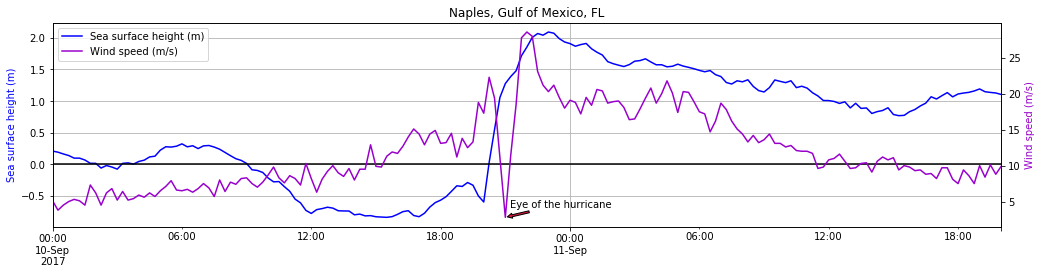

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    station = "8725110"

    w = [obs for obs in winds_observations if obs._metadata["station_code"] == station][
        0
    ]
    s = [obs for obs in ssh_observations if obs._metadata["station_code"] == station][0]

    fig, ax = plt.subplots(figsize=(17, 3.75))
    s["2017-9-10":].plot(ax=ax, label="Sea surface height (m)", color="#0000ff")
    ax1 = w["2017-9-10":].plot(
        ax=ax, label="Wind speed (m/s)", color="#9900cc", secondary_y=True
    )
    ax.set_title(w._metadata["station_name"])

    lines = ax.get_lines() + ax.right_ax.get_lines()
    ax.legend(lines, [l.get_label() for l in lines], loc="upper left")
    ax.axhline(0, color="black")

    ax.set_ylabel("Sea surface height (m)", color="#0000ff")
    ax.right_ax.set_ylabel("Wind speed (m/s)", color="#9900cc")

    ax1.annotate(
        "Eye of the hurricane",
        xy=(w["2017-9-10":].argmin().to_pydatetime(), w["2017-9-10":].min()),
        xytext=(5, 10),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="simple", facecolor="crimson"),
    )

    ax.grid(True)
except Exception:
    print("Cannot find station {}".format(station))

We can observe the sea level retreating around 10-Sep 9:00 and then a significant surge after 19:00.
The lower winds at beginning of the surge is probably the eye of the hurricane.

For our interactive map we will use [`bokeh`](https://bokeh.pydata.org/en/latest) HTML plots instead of the usual raster [`matplotlib`](https://matplotlib.org) ones to enhance the user experience when exploring the graphs.

In [18]:
from bokeh.embed import file_html
from bokeh.models import HoverTool, LinearAxis, Range1d
from bokeh.plotting import figure
from bokeh.resources import CDN
from folium import IFrame

# Plot defaults.
tools = "pan,box_zoom,reset"
width, height = 750, 250


def make_plot(ssh, wind):
    p = figure(
        toolbar_location="above",
        x_axis_type="datetime",
        width=width,
        height=height,
        tools=tools,
        title=ssh.name,
    )

    p.yaxis.axis_label = "wind speed (m/s)"

    l0 = p.line(
        x=wind.index,
        y=wind.values,
        line_width=5,
        line_cap="round",
        line_join="round",
        legend="wind speed (m/s)",
        color="#9900cc",
        alpha=0.5,
    )

    p.extra_y_ranges = {}
    p.extra_y_ranges["y2"] = Range1d(start=-1, end=3.5)

    p.add_layout(LinearAxis(y_range_name="y2", axis_label="ssh (m)"), "right")

    l1 = p.line(
        x=ssh.index,
        y=ssh.values,
        line_width=5,
        line_cap="round",
        line_join="round",
        legend="ssh (m)",
        color="#0000ff",
        alpha=0.5,
        y_range_name="y2",
    )

    p.legend.location = "top_left"

    p.add_tools(
        HoverTool(tooltips=[("wind speed (m/s)", "@y"),], renderers=[l0],),
        HoverTool(tooltips=[("ssh (m)", "@y"),], renderers=[l1],),
    )
    return p


def make_marker(p, location, fname):
    html = file_html(p, CDN, fname)
    iframe = IFrame(html, width=width + 45, height=height + 80)

    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color="green", icon="stats")
    marker = folium.Marker(location=location, popup=popup, icon=icon)
    return marker

Here is the final result. Explore the map by clicking on the map features plotted!

In [19]:
import folium
from folium.plugins import Fullscreen, MarkerCluster
from ioos_tools.ioos import get_coordinates

lon = track.centroid.x
lat = track.centroid.y

m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=4)

Fullscreen(position="topright", force_separate_button=True).add_to(m)

marker_cluster0 = MarkerCluster(name="Observations")
marker_cluster1 = MarkerCluster(name="Past predictions")
marker_cluster0.add_to(m)
marker_cluster1.add_to(m)


url = "http://oos.soest.hawaii.edu/thredds/wms/hioos/satellite/dhw_5km"
w0 = folium.WmsTileLayer(
    url,
    name="Sea Surface Temperature",
    fmt="image/png",
    layers="CRW_SST",
    attr="PacIOOS TDS",
    overlay=True,
    transparent=True,
)

w0.add_to(m)

url = "http://hfrnet.ucsd.edu/thredds/wms/HFRNet/USEGC/6km/hourly/RTV"
w1 = folium.WmsTileLayer(
    url,
    name="HF Radar",
    fmt="image/png",
    layers="surface_sea_water_velocity",
    attr="HFRNet",
    overlay=True,
    transparent=True,
)

w1.add_to(m)


def style_function(feature):
    return {
        "fillOpacity": 0,
        "color": "black",
        "stroke": 1,
        "weight": 0.5,
        "opacity": 0.2,
    }


# Latest cone prediction.
latest = cones[-1]
folium.GeoJson(
    data=latest.__geo_interface__,
    name="Cone prediction as of {}".format(latest["ADVDATE"].values[0]),
).add_to(m)

# Past cone predictions.
for cone in cones[:-1]:
    folium.GeoJson(data=cone.__geo_interface__, style_function=style_function,).add_to(
        marker_cluster1
    )

# Latest points prediction.
for k, row in pts.iterrows():
    date = row["FLDATELBL"]
    hclass = row["TCDVLP"]
    location = row["LAT"], row["LON"]
    popup = "{}<br>{}".format(date, hclass)
    folium.CircleMarker(
        location=location, radius=10, fill=True, color=colors[hclass], popup=popup,
    ).add_to(m)

# All the points along the track.
for point in points:
    date = point["FLDATELBL"]
    hclass = point["TCDVLP"]
    location = point["LAT"], point["LON"]
    popup = "{}<br>{}".format(date, hclass)
    folium.CircleMarker(
        location=location, radius=5, fill=True, color=colors[hclass], popup=popup,
    ).add_to(m)


# Observations.
for ssh, wind in zip(ssh_observations, winds_observations):
    fname = ssh._metadata["station_code"]
    location = ssh._metadata["lat"], ssh._metadata["lon"]
    p = make_plot(ssh, wind)
    marker = make_marker(p, location=location, fname=fname)
    marker.add_to(marker_cluster0)

folium.LayerControl().add_to(m)

p = folium.PolyLine(get_coordinates(bbox), color="#009933", weight=1, opacity=0.2)

p.add_to(m)

In [20]:
def embed_map(m):
    from IPython.display import HTML

    m.save("index.html")
    with open("index.html") as f:
        html = f.read()

    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    srcdoc = html.replace('"', "&quot;")
    return HTML(iframe.format(srcdoc=srcdoc))


embed_map(m)

/home/filipe/miniconda3/envs/IOOS/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
